In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
import trackpy as tp
import pims
from fetch import fetch

mpl.style.use('http://tiny.cc/leheny-style-sans-serif/raw')

In [4]:
VIDEO_NUMBER = 6

In [5]:
v = pims.open(fetch('photoactivation-project', '20140426 Fibrin MPT/20140426 20fps 170nm PLGA-PEG {0}.tif'.format(VIDEO_NUMBER)))

Fetching data from S3...


In [6]:
v

<Frames>
Source: /Users/danielallan/Fetch/photoactivation-project/20140426 Fibrin MPT/20140426 20fps 170nm PLGA-PEG 6.tif
Length: 300 frames
Frame Shape: 512 x 512
Pixel Datatype: H

Frame([[654, 659, 659, ..., 652, 658, 650],
       [646, 652, 656, ..., 658, 676, 669],
       [653, 660, 666, ..., 673, 662, 675],
       ..., 
       [653, 666, 654, ..., 647, 661, 663],
       [653, 647, 653, ..., 650, 663, 658],
       [651, 640, 649, ..., 658, 648, 646]], dtype=uint16)
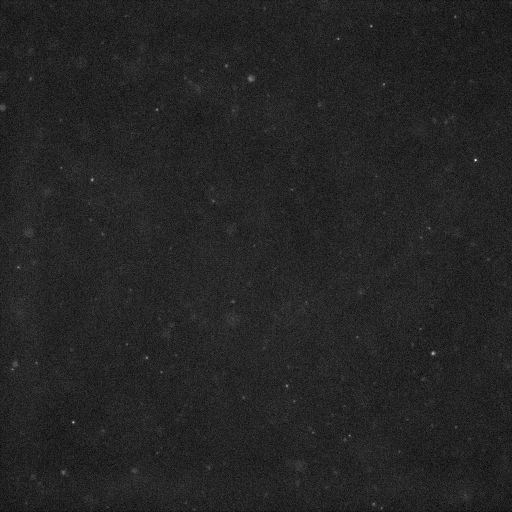

In [7]:
v[-1]

Note: FFTW is configuring itself. This will take several seconds, but subsequent calls will run *much* faster.


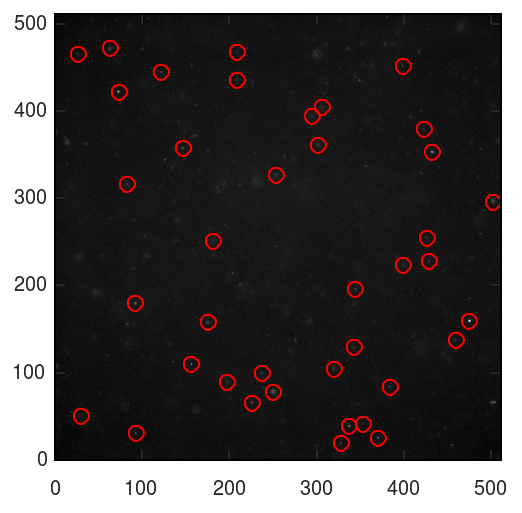

In [8]:
f = tp.locate(v[5], 11, minmass=2e5)
f = f.query('signal > 0 & ecc < 0.15 & size < 3')
tp.annotate(f, v[5])

/home/dallan/pandas-danielballan/pandas/tools/plotting.py:2919: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "is being cleared", UserWarning)


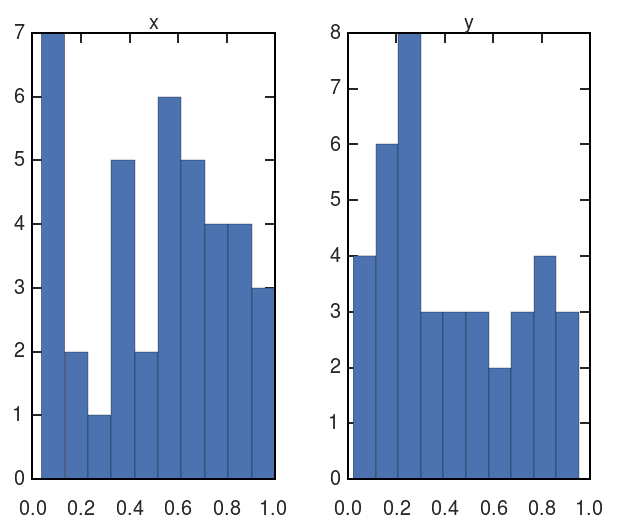

In [7]:
tp.subpx_bias(f)

In [8]:
with tp.PandasHDFStore('data/20140426-fibrin-plga-peg-{0}.h5'.format(VIDEO_NUMBER)) as s:
    for frame in v:
        f = tp.locate(frame, 11, minmass=2e5)
        f = f.query('signal > 0 & ecc < 0.15 & size < 3')
        if len(f) == 0:
            continue
        s.put(f)
        tp.print_update('Frame {0} of {1}'.format(frame.frame_no, len(v)))

Frame 299 of 300


In [9]:
with tp.PandasHDFStore('data/20140426-fibrin-plga-peg-{0}.h5'.format(VIDEO_NUMBER)) as s:
    for linked in tp.link_df_iter(s, 10, memory=15):
        s.put(linked)

Frame 299: 69 trajectories present


In [9]:
with tp.PandasHDFStore('data/20140426-fibrin-plga-peg-{0}.h5'.format(VIDEO_NUMBER)) as s:
    t = s.dump()

IOError: ``/Users/danielallan/Documents/Repos/jhu-thesis-template/data`` does not exist

In [ ]:
t1 = tp.filter_stubs(t, 30)

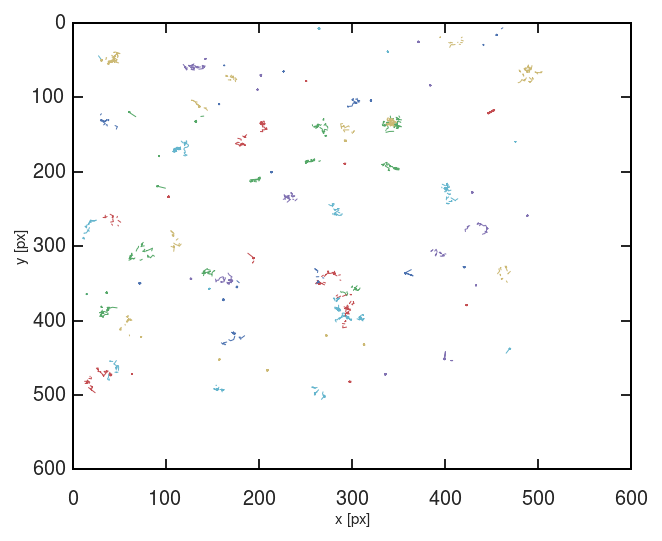

In [12]:
tp.plot_traj(t1)

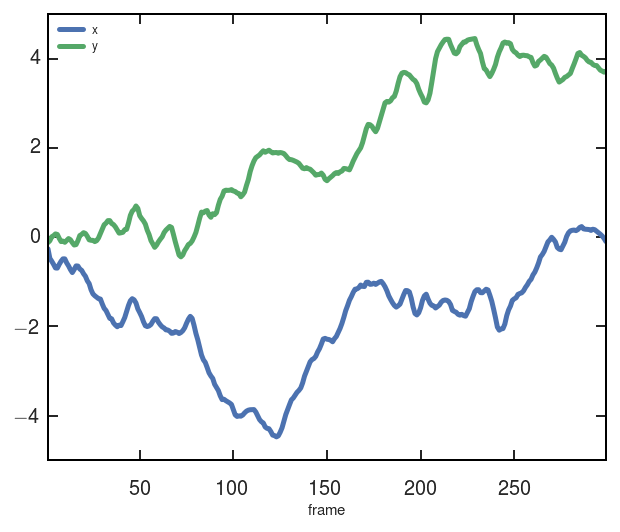

In [13]:
d = tp.compute_drift(t, 5)
tm = tp.subtract_drift(t1, d)
d.plot()

In [14]:
CALIBRATION = {'fps': 1/50e-3, 'mpp': 0.2457}
im = tp.imsd(tm, **CALIBRATION)

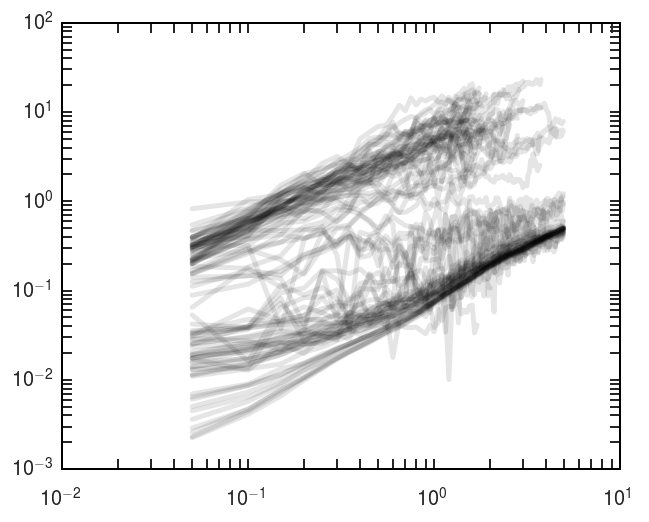

In [15]:
fig, ax = plt.subplots()
ax.loglog(im.index, im, color='black', alpha=0.1);

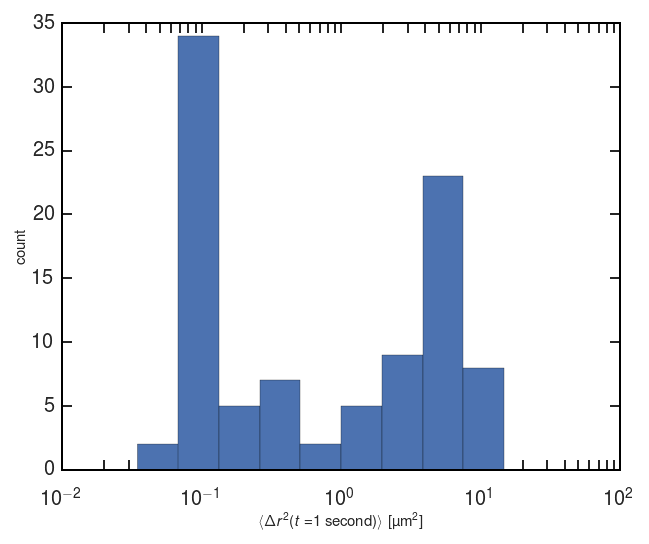

In [16]:
im_cut = im.loc[1]  # msd at 1 second
ax = im_cut.hist(bins=np.logspace(np.log10(im_cut.min()), np.log10(im_cut.max()), num=10))
ax.set(xscale='log', xlabel=r'$\langle\Delta r^2 (t=$1 second)$\rangle$ [\textmu m$^2$]', ylabel='count');